# Statistical Models

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from darts import TimeSeries
from helpers import *
sns.set_theme(context="notebook", style="whitegrid", color_codes=True, rc={"figure.figsize": (6, 2)})

### Load data

In [2]:
date = "20240102"
atm_strike = get_option_atm_strike(date)
quotes = get_option_quotes(date)

atm strike: 4745000
Number of quotes loaded: 504021


In [3]:
df = quotes[quotes['strike'] == atm_strike].copy()
df = df.drop(columns=['strike', 'ms_of_day', 'put_mid'])

In [4]:
# Remove for rows where value is zero.  Should only be start of the day
zero_call_mid_rows = df[df['call_mid'] == 0]
print(zero_call_mid_rows)
df = df[df['call_mid'] != 0]

                     call_mid
ts                           
2024-01-02 09:30:00       0.0
2024-01-02 09:30:01       0.0
2024-01-02 09:30:02       0.0
2024-01-02 09:30:03       0.0


### Stationary with log_rtn

In [11]:
df["log_rtn"] = np.log(df["call_mid"]/df["call_mid"].shift(1))
df = df[["call_mid", "log_rtn"]].dropna()

### Statistical forecasting
MAPE: < 10% Excellent; 10%-20% Good; 20%-50% Reasonable.  Requires positive values.

Run #1: fit with call_mid 
* ExponentialSmoothing(seasonal_periods=60) obtains MAPE: 785.16%
* TBATS() obtains MAPE: 1201.72%
* AutoARIMA() obtains MAPE: 1196.57%
* Theta() obtains MAPE: 911.83%

Run #2: fit with log_rtn   
* MAE because MAPE requires positive values.
* model ExponentialSmoothing(seasonal_periods=60) obtains MAE: 0.01%
* model TBATS() obtains MAE: 0.01%
* model AutoARIMA() obtains MAE: 0.01%


<Axes: xlabel='ts'>

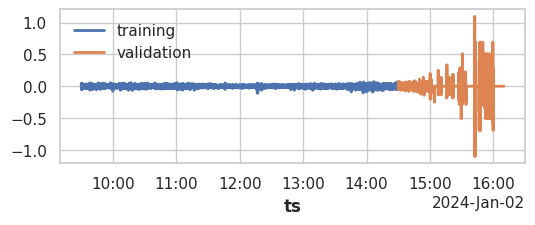

In [19]:
# series = TimeSeries.from_dataframe(df, value_cols='call_mid') # Run #1
series = TimeSeries.from_dataframe(df, value_cols='log_rtn') # Run #2
train, val = series.split_after(0.75)
train.plot(label="training")
val.plot(label="validation")

### NOTE.  FIX ^^^.   ITS USING LAST HOUR FOR VALIDATION...

In [ ]:
from darts.metrics import mape, mae
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="statsmodels")

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    # print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")
    print(f"model {model} obtains MAE: {mae(val, forecast):.2f}%")

eval_model(ExponentialSmoothing(seasonal_periods=60)) # StatsModels chokes on S interval, so provide seasonal_periods
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

### Hyper-parameter optimization example

In [7]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)
best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(f"Lowest MAPE is: {mape(val, pred_best_theta):.2f}, with theta = {best_theta}.")

Lowest MAPE is: 207.98, with theta = -1.0612244897959187.


---
### Backtesting
* Copy from Darts Quickstart